In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget
# %matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (12,4)

# Test de l'implémentation de l'article d'Antunes et Debut

In [2]:
L = 0.65 #longueur de corde (m)
f1 = 110 #freq de la corde (hz)
T = 73.9 #tension de la corde (N)
rho_l = 3.61 * 10**(-3) #masse linéique (kg/m)
ct = np.sqrt(T/rho_l) #célérité des ondes transverse (M/s)
B = 4*10**(-5) #coefficient d'inarmonicité : B = E*I (N*m**2)

In [3]:
#Discrétisation
Nm = 100 #Modes
Nn = np.arange(1,Nm+1)

Nx = 1000
x = np.linspace(0,L,Nx)

phi_Nx_Nm = np.sin((2*Nn[np.newaxis,:]-1)*np.pi*x[:,np.newaxis]/2/L)

pn = (2 * Nn - 1) * np.pi / (2 * L)
fn = (ct / 2 / np.pi) * pn * (1 + pn**2 * B / (2 * T))
wn = 2*np.pi*fn

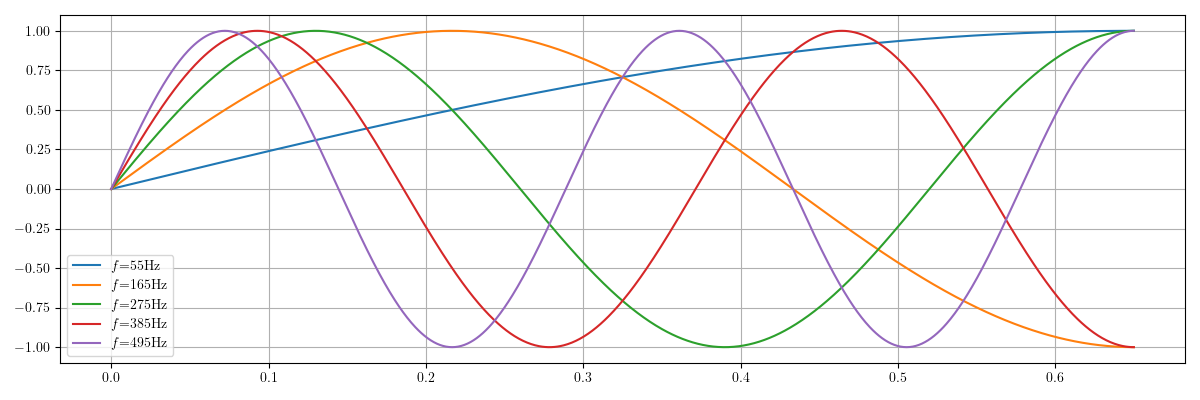

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(5) :
    ax1.plot(x,phi_Nx_Nm[:,i],label=f"$f$={fn[i]:.0f}Hz")
ax1.grid()
ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title(r"")
ax1.set_xlim()
ax1.set_ylim()

fig.tight_layout()

plt.show()

In [5]:
etaf, etaA, etaB = 7e-5, 0.9, 2.5e-2

xin = 1/2 * ( T*(etaf + etaA/2/np.pi/fn) + etaB*B*pn**2 ) /(T + B*pn**2)

Mm = rho_l * L / 2  #masse modale corde

MS = np.diag(np.array([Mm]*Nm))
CS = MS * np.diag(2*wn*xin)
KS = MS*np.diag(wn**2)

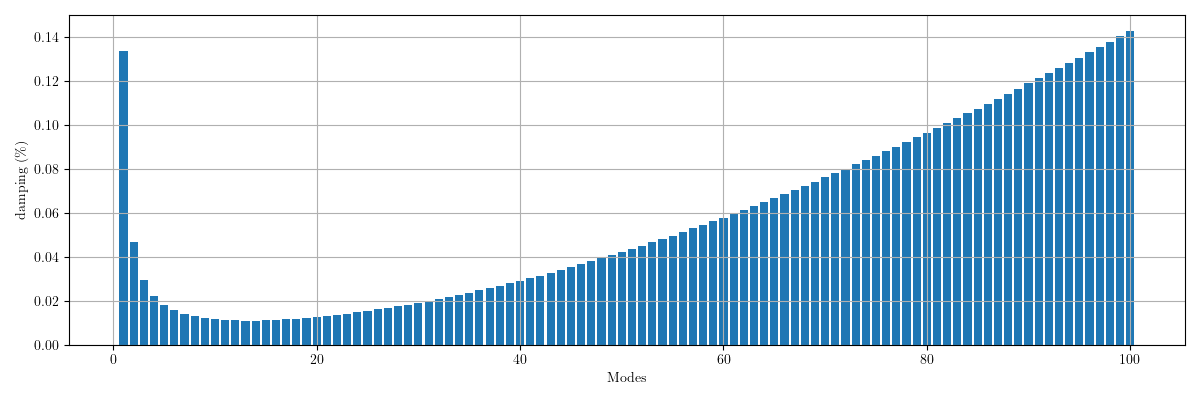

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.bar(Nn,xin*100,label="")
ax1.grid()
#ax1.legend()
ax1.set_xlabel("Modes")
ax1.set_ylabel("damping (\%)")
ax1.set_title(r"")
ax1.set_xlim()
ax1.set_ylim()

fig.tight_layout()

plt.show()

In [7]:
xinB = np.array([2.2,1.1,1.6,1.0,0.7,0.9,1.1,0.7,1.4,0.9,0.7,0.7,0.6,1.4,1.0,1.3])/100
fnB = np.array([78.3,100.2,187.3, 207.8, 250.9,291.8,314.7,344.5,399.0,429.6,482.9,504.2,553.9,580.3,645.7,723.5])
mnB = np.array([2.91,0.45,0.09,0.25,2.65,9.88,8.75,8.80,0.90,0.41,0.38,1.07,2.33,1.36,2.02,0.45])
NmB = len(fnB)
NnB = np.arange(1,NmB+1)

wnB = 2*np.pi*fnB

MB = np.diag(mnB)
CB = np.diag(2*mnB*wnB*xinB)
KB = np.diag(mnB*wnB**2)

In [8]:
#Matrices concaténées par bloc

M = np.block([
              [MS               , np.zeros((Nm,NmB))],
              [np.zeros((NmB,Nm)), MB               ]
])

K = np.block([
              [KS               , np.zeros((Nm,NmB))],
              [np.zeros((NmB,Nm)), KB               ]
])

C = np.block([
              [CS               , np.zeros((Nm,NmB))],
              [np.zeros((NmB,Nm)), CB               ]
])

In [9]:
show_matrixes = False
if show_matrixes :    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    img = ax1.imshow(MB,
        aspect="auto")
    ax1.set_title("MB")

    fig.colorbar(img,ax=ax1)

    img2 = ax2.imshow(MS,
        aspect="auto")
    ax2.set_title("MS")

    fig.colorbar(img2,ax=ax2)

    fig.tight_layout()

    plt.show()

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    img = ax1.imshow(M)
    ax1.set_title("Mtot")

    fig.colorbar(img,ax=ax1)

    fig.tight_layout()

    plt.show()

In [10]:
#On dit dans un premier temps que la corde est attachée à gauche et à droite (on appuie pas dessus)

phiSB = phi_Nx_Nm[-1,:] #dernier indice en x => x=L
phiSF = phi_Nx_Nm[250,:] #premier indice en x : x=0

Aa1 = np.block([
                [phiSB.T, np.zeros(NmB)],
                [phiSF.T, np.zeros(NmB)]
])

Aa2 = np.block([
                [phiSB.T, -np.ones(NmB)],
                [phiSF.T, np.zeros(NmB)]
])

B = Aa1 @ np.linalg.inv(M**(1/2))

Bplus = B.T @ np.linalg.inv((B @ B.T))

W = np.eye(Nm+NmB) - np.linalg.inv(M**(1/2)) @ Bplus @ Aa1

In [11]:
#Fext dépend du temps

Fe = 4000
tfin = 10 #s
t = np.linspace(0,tfin,tfin*Fe)
Nt = len(t)

# deltat = 1e-5 #pas de discrétisation : s
# Fe = int(1/deltat)
# tfin = 10 #temps final d'intégration
# t = np.linspace(0,tfin,tfin*Fe)
# Nt = len(t)

## déf de la force : 
Fext = np.zeros_like(t)
idx_deb = 0
idx_fin = 1*Fe
Fext[idx_deb:idx_fin] = np.linspace(0,1,idx_fin - idx_deb) * 5

import mymodule as mm

xe_idx = mm.find_nearest_index(x, 0.9*L)

FextS_Nx_Nt = np.zeros((Nx,Nt))

FextS_Nx_Nt[xe_idx, : ] = Fext

#Projection de la force dans la base modale de la corde

Fmod_Nm_Nt = phi_Nx_Nm.T @ FextS_Nx_Nt

In [12]:
import control

MSinv = np.linalg.inv(MS)
MBinv = np.linalg.inv(MB)

ABG = W @ np.block([
    [-MSinv @ KS, np.zeros((Nm,NmB))],
    [np.zeros((NmB, Nm)), -MBinv @ KB]
])
ABD = W @ np.block([
    [-MSinv @ CS, np.zeros((Nm,NmB))],
    [np.zeros((NmB, Nm)), -MBinv @ CB]
])

A = np.block([
    [np.zeros((Nm+NmB,Nm+NmB)) , np.eye(Nm+NmB)],
    [ ABG         , ABD      ]
])

B = np.block([
    [np.zeros((Nm+NmB, Nx))],
    [W @ np.block([
        [MSinv @ phi_Nx_Nm.T],
        [np.zeros((NmB, Nx))]
        ])]
])

C = np.block([
    [np.eye(Nm+NmB) ,  np.zeros((Nm+NmB,Nm+NmB))]
])
#C permet d'observer la position avec les Nm premieres contributions des modes de la corde et ensuite les NmB de la plaque

D = 0

sys = control.StateSpace(A,B,C,D)

U = FextS_Nx_Nt
# U = np.zeros((Nx,Nt))
# U[500,0]=1

t, Q = control.forced_response(sys, T=t, U=U, X0=0)

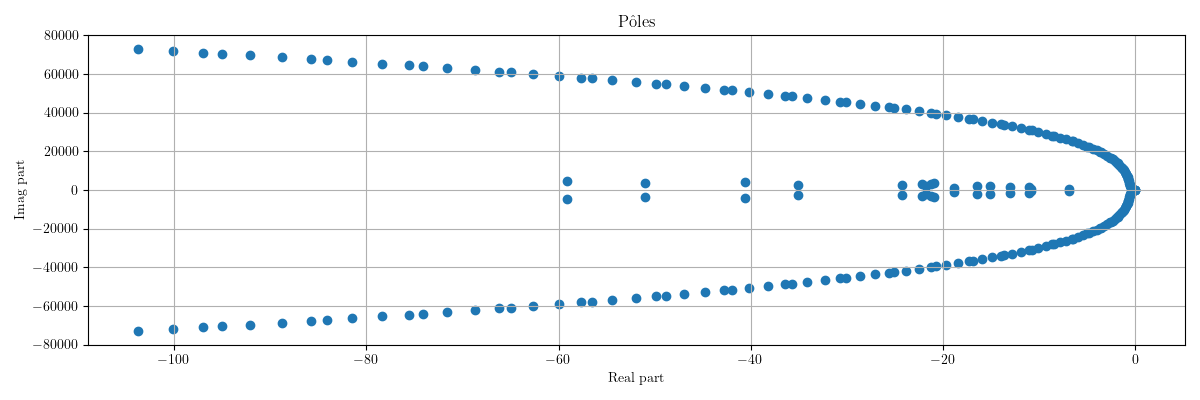

In [13]:
w, _ = np.linalg.eig(A)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.real(w),np.imag(w),label="")
ax1.grid()
#ax1.legend()
ax1.set_xlabel("Real part")
ax1.set_ylabel("Imag part")
ax1.set_title(r"Pôles")
ax1.set_xlim()
ax1.set_ylim()

fig.tight_layout()

plt.show()

In [14]:
#Pour repasser sur les coordonnées de la corde
xcorde_Nx_Nt = phi_Nx_Nm @ Q[:Nm,:]

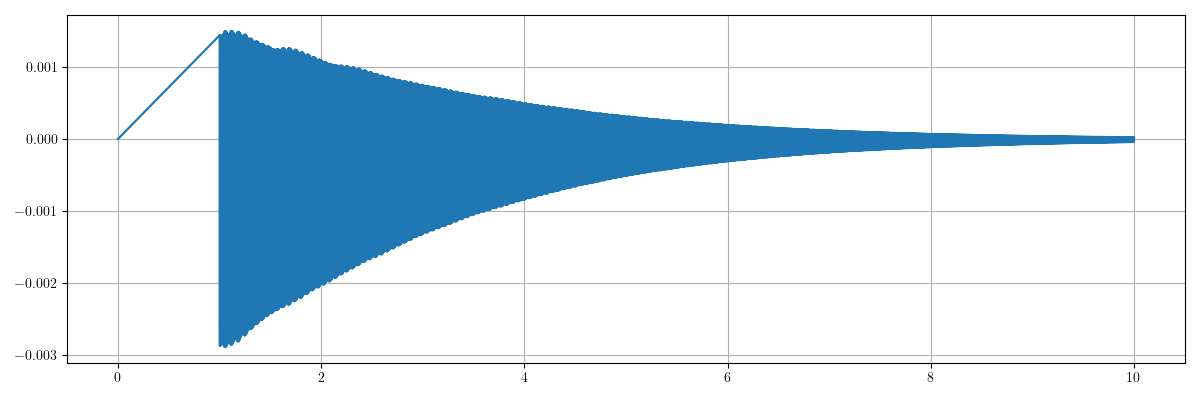

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(t,xcorde_Nx_Nt[500,:],label="")
ax1.grid()
#ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title(r"")
ax1.set_xlim()
ax1.set_ylim()

fig.tight_layout()

plt.show()

In [16]:
from IPython.display import display, Audio

display(Audio(xcorde_Nx_Nt[500,:], rate=Fe))

## Exportation gif de la corde qui bouge

In [19]:
fe_anim = 15     #Hz

N_interval_anim = int(Fe/fe_anim)   #Nombre de points entre 0 et 1/fe_anim secondes

Ntanim = int(Nt/N_interval_anim)    #Nombre de points total de l'échantillonage visuel en fe_anim FPS
rms_Ntanim_Nx = np.zeros((Ntanim,Nx))
t_anim = np.zeros(Ntanim)
for i in range(Ntanim) :
    # rms_Ntanim_Nx[i,:] = np.sqrt(np.sum(np.square(xcorde_Nx_Nt[:,i*N_interval_anim:i*N_interval_anim+N_interval_anim-1]),axis=1))
    rms_Ntanim_Nx[i,:] = xcorde_Nx_Nt[:,i*N_interval_anim]
    t_anim[i] = t[i*N_interval_anim]

rms_Nx_Ntanim = rms_Ntanim_Nx.T

MovieWriter PillowWriter unavailable; using Pillow instead.


Done ✅


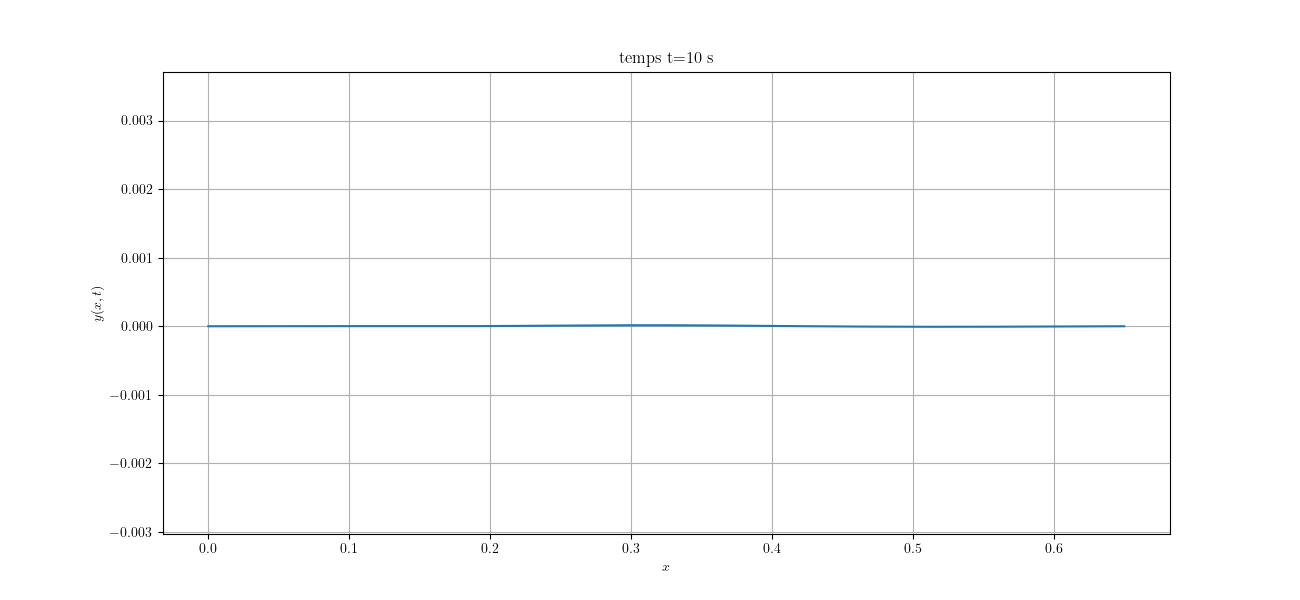

In [20]:
fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(111)

line, = ax1.plot(x,rms_Nx_Ntanim[:,0],label="")
ax1.grid()
# ax1.legend()
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y(x,t)$")
ax1.set_title(f"temps t={t_anim[0]}s")
ax1.set_ylim(np.min(rms_Nx_Ntanim),np.max(rms_Nx_Ntanim))

def init() :
    line.set_ydata(rms_Nx_Ntanim[:,0])
    line.set_xlim()
    ax1.set_title(f"temps t={t_anim[0]}s")
    return line,

def update(t_idx) :
    line.set_ydata(rms_Nx_Ntanim[:,t_idx])
    ax1.set_title(f"temps t={t_anim[t_idx]:.0f} s")
    return line,

import matplotlib.animation as animation

myAnimation = animation.FuncAnimation(fig, update, frames=Ntanim, interval=1/fe_anim, blit=True, repeat=False)
print("Done ✅")

myAnimation.save("figures_vico/gif_corde.gif", writer='PillowWriter', fps=fe_anim)